---
execute:
  echo: true
  enabled: false
  output: true
  warning: false
format:
    html:
        code-fold: false
---

# Detect malware (RF normed-1-0-0-0)

The model deployment is done in two stages: I. tune the model, II. turn on the malware detection (on the data collected in B1 and B2 periods respectively, described in the timeline @fig-timeline)

![Timeline](../../imgs/timeline.png)

### Stage I: Model tuning

On this state we fit the scaler on the data collected in B1 period, to be used later on the second stage

In [1]:
#| echo: false
#| output: false
basepath = "/home/u1/"

In [2]:
#| echo: false
#| output: false
import os
os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [3]:
from detect_common import *

In [4]:
#| output: false
p1version = "v6"
p2version = "v7"
p3version = "v5"

In [5]:
model = 'RF'
normed = True
skips_and_weights = [2,4,0,0]

In [6]:
# Parameters
model = "RF"
normed = True
skips_and_weights = [1, 0, 0, 0]


In [7]:
import dateutil.parser

df_b1 = pd.read_feather("cached/v5_1.ft")

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Perhaps you already have a cluster running?
Hosting the HTTP server on port 35345 instead


In [8]:
path_doh_ips_androids = basepath + "datasets/flubot20230323/data/v5_benign_doh_ips.csv"
path_doh_ips_general = "doh_resolver_ip.csv"
full_list = get_doh_ips(path_doh_ips_androids) + get_doh_ips(path_doh_ips_general)

cp = CacheableProcessing(100, 100, full_list)
df_b1_p = cp.process(df_b1, f"cached/v5_1.p3.{p3version}.cp.ft")

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Reason: `lines` argument not supported


In [9]:
from joblib import dump, load

name = (
    ('normed-' if normed else 'unnormed-') + 
    '-'.join(str(p) for p in skips_and_weights)
)

clf = load(f'models/{model}-mix-1-p-{name}.p1.{p1version}.p2.{p2version}.joblib')


In [10]:
pp_b1 = PreProcessing(normed, *skips_and_weights)

df_b1_pp = pp_b1.process(
    df_b1_p,
    f"cached/p3.{p3version}.pp.{model}-{name}.saved", 
    fit_new_scaler=True
)

Reason: `lines` argument not supported


Reason: `lines` argument not supported


Reason: `lines` argument not supported


In [11]:
pp_b1.store_scaler(
    f"cached/p3.{p3version}.pp.{model}-{name}.scaler"
)

### Stage II: Malware detection

On this state we turn on the malware detection, provisioning the model with the scaler trained before. For malware detection we use the data trained in B2 period.

In [12]:
df_b2 = pd.read_feather("cached/v5_2.ft")

In [13]:
cp = CacheableProcessing(100, 100, full_list)
df_b2_p = cp.process(df_b2, f"cached/v5_2.p3.{p3version}.cp.ft")

Reason: `lines` argument not supported


In [14]:
pp_b2 = PreProcessing(normed, *skips_and_weights)
pp_b2.load_scaler(
    f"cached/p3.{p3version}.pp.{model}-{name}.scaler"
)
df_b2_pp, df_b2_pp_features, df_b2_pp_labels = pp_b2.process(
    df_b2_p,
    f"cached/b2.p3.{p3version}.pp.{model}-{name}.saved", 
    fit_new_scaler=False  # use scaler trained in B1
)

Reason: `lines` argument not supported


Reason: `lines` argument not supported


Reason: `lines` argument not supported


In [15]:
def predict(pp, clf, threshold, df_pp, df_orig):
    """
    pp: PreProcessing object
    clf: classifier
    threshold: >=threshold for positive (DoH) class
    df_pp: preprocessed dataframe
    df_orig: unprocessed dataframe
    """
    df_pp2 = df_pp.copy()

    df_pp2["IsDoHPredicted"] = (clf.predict_proba(df_pp2[pp.feature_fields])[:,1] >= threshold).astype(bool)

    df_orig2 = df_orig.copy()
    # fill predicted to the original dataframe
    df_orig2["IsDoHPredicted"] = df_pp2["IsDoHPredicted"]
    # non-443 rows will be NaN, replace with False
    df_orig2["IsDoHPredicted"] = df_orig2["IsDoHPredicted"].fillna(False)

    return df_orig2


In [16]:
results_df = pd.read_feather(f"cached/robustness.balanced_mix-results.p3.{p3version}.ft")
results_df["skips_and_weights"] = results_df["skips_and_weights"].apply(str)
model, normed, skips_and_weights_str, auc, fprs, tprs, thresholds = results_df[
    (results_df["model"] == model) & (results_df["normed"] == normed) & (results_df["skips_and_weights"] == str(np.array(skips_and_weights)))
].iloc[0]

In [17]:
data = {}
for sensitivity in [0.8, 0.9]:
    threshold = [threshold for tpr, threshold in zip(tprs, thresholds) if tpr >= sensitivity][0]
    df_pred = predict(pp_b2, clf, threshold, df_b2_pp, df_b2)
    data[sensitivity] = {
        'df': df_pred,  # dataframe with predicted values,
        'threshold': threshold,
    }


In [18]:
def calc(df_n):
    def rate(df_h):
        dns_packets = df_h[df_h["IsDoHPredicted"] == True]["uint32 PACKETS"].sum()  # outgoing packets
        non_dns_ips = set(df_h[df_h["IsDoHPredicted"] == False]["ipaddr SRC_IP"].unique()).union(
            set(df_h[df_h["IsDoHPredicted"] == False]["ipaddr DST_IP"].unique()))
        rate = float(dns_packets) / (1.0 + len(non_dns_ips))
        return {"dns_packets": dns_packets, "non_dns": len(non_dns_ips), "rate": rate, "rate_log": np.log(rate)}

    return pd.DataFrame({ ip: rate(grp) for ip, grp in df_n.groupby(["ipaddr SRC_IP"]) }).T.reset_index()


#### Calculate ratio on the whole dataset

In [19]:
for sensitivity, value in data.items():
    print(sensitivity)
    df_pred = value["df"]
    local_df = df_pred[df_pred["ipaddr SRC_IP"].str.startswith("192.168")]
    display(calc(local_df))


0.8


2023-03-25 10:50:27,685 - distributed.worker - ERROR - Exception during execution of task lambda-cfdda9654fdb2d9bad5ba60bd9582ca3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-09255a73-c871-442e-a04f-ef7527f080c5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

,index,dns_packets,non_dns,rate,rate_log
0,192.168.1.1,0.0,2.0,0.00000,-inf
1,192.168.2.149,273854.0,4415.0,62.01404,4.127361
2,192.168.2.217,96561.0,17.0,5364.50000,8.587558
3,192.168.2.249,190943.0,3532.0,54.04557,3.989828
4,192.168.2.42,0.0,5.0,0.00000,-inf


0.9


2023-03-25 10:51:54,004 - distributed.worker - ERROR - Exception during execution of task lambda-034f5000d753f2fe6ad612b2dba3cd21.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-9d0c832d-811a-43ff-98fb-877f5d15de80'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:52:16,430 - distributed.worker - ERROR - Exception during execution of task lambda-19bea76c15da5520789c64ad9fd71b75.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-d872ce9d-c358-4e96-8663-3b1588eeaa23'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 10:52:49,858 - distributed.worker - ERROR - Exception during execution of task lambda-86eba95d5fc2ddf47cc1f0e763f8f245.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-38353f1d-9cde-4f09-815a-fef9cc67fe7e'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

,index,dns_packets,non_dns,rate,rate_log
0,192.168.1.1,0.0,2.0,0.000000,-inf
1,192.168.2.149,354693.0,3953.0,89.704856,4.496525
2,192.168.2.217,699158.0,15.0,43697.375000,10.685043
3,192.168.2.249,264365.0,3179.0,83.133648,4.420450
4,192.168.2.42,0.0,5.0,0.000000,-inf


#### Split into time windows

In [20]:
min_ts = df_b2["time TIME_FIRST"].apply(dateutil.parser.parse).min()
min_ts

Timestamp('2023-03-23 14:50:04.316951')

In [21]:
local_ips = df_b2[df_b2["ipaddr SRC_IP"].str.startswith("192.168")]["ipaddr SRC_IP"].unique().tolist()
local_ips

['192.168.2.249',
 '192.168.2.149',
 '192.168.2.42',
 '192.168.2.217',
 '192.168.1.1']

In [22]:
f = '3min'

for sensitivity, value in data.items():
    print(sensitivity)

    df_pred = value["df"]
    local_df = df_pred[df_pred["ipaddr SRC_IP"].str.startswith("192.168")].copy()
    local_df["time TIME_FIRST"] = local_df["time TIME_FIRST"].apply(dateutil.parser.parse)
    
    calc_ips = {}

    a1_t = local_df.set_index(["time TIME_FIRST"])

    df_resample = a1_t.groupby(pd.Grouper(freq=f, origin=min_ts)).first()
    times = df_resample.index.tolist()
    ranges = list(zip(times, times[1:]))

    df_calcs = []
    for ran in ranges:
        df_ran = a1_t[(a1_t.index > ran[0]) & (a1_t.index < ran[1])]
        df_calc = calc(df_ran)
        df_calc["ts"] = ran[0]
        df_calcs.append(df_calc)

    value["df_calc"] = pd.concat(df_calcs).reset_index(drop=True)

0.8


2023-03-25 10:54:22,516 - distributed.worker - ERROR - Exception during execution of task lambda-d9484918b76c2a0bfa55380270e06239.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-5d4a87f2-067c-4e5c-9d3f-aefd5529eb3f'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:54:24,748 - distributed.worker - ERROR - Exception during execution of task lambda-c0f25d5a1de7d522404388f05c849048.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-60ae13fb-5a14-4ce2-8f07-576800bfe707'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:54:31,500 - distributed.worker - ERROR - Exception during execution of task lambda-271d48c9c98107c761d4a7c2077dd1e2.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-226fee44-f402-4a12-9e0c-87a1b041d044'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:54:53,184 - distributed.worker - ERROR - Exception during execution of task lambda-0a61c9cc6a4c585acbd379dd8f4f9e88.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-b83548d5-65cd-4ae3-b529-4de5fdfcd3b3'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:55:15,523 - distributed.worker - ERROR - Exception during execution of task lambda-a9ef429e5e9cb8130931ddda6d6ee28d.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-f1c662e0-43e0-4f70-9412-3e71e0a594fa'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 10:55:20,681 - distributed.worker - ERROR - Exception during execution of task lambda-17495162f280280d7796bc9e706a155c.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-418d0246-7f19-448a-97a6-a4e4f2bd081a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 10:56:03,348 - distributed.worker - ERROR - Exception during execution of task lambda-35163fd690863923834ecde4c1e14f82.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-17b0dffb-2eee-4cbc-b6e3-3e9487091323'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:56:14,264 - distributed.worker - ERROR - Exception during execution of task lambda-e28a5589ad39a41b14ba347121c1a9e3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-bd301771-3770-4d69-bdcb-127f9dbf1f80'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:56:15,851 - distributed.worker - ERROR - Exception during execution of task lambda-766526c7c3c24223c349c00a5e2585fc.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-377dd27d-2cf7-4e28-aa76-889ec90fd9c1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 10:56:35,855 - distributed.worker - ERROR - Exception during execution of task lambda-ce29fee54bda003f3743dd9cb5c080df.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-0cadedd9-8ebc-4226-8953-9a05851d7034'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:56:38,431 - distributed.worker - ERROR - Exception during execution of task lambda-ca74f4d217185ae1d84298444e6523a7.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-8a7333ac-4901-49ad-b223-c9e944890082'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:56:59,041 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


2023-03-25 10:57:05,018 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


2023-03-25 10:57:10,812 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


2023-03-25 10:57:11,129 - distributed.worker - ERROR - Exception during execution of task lambda-b67835702fa6cbd689e6161b9d8620d1.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-f337abf2-0fb8-48ee-8810-2acd6c5395a7'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 10:57:17,268 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 10:57:19,664 - distributed.worker - ERROR - Exception during execution of task lambda-aa57a602a3e466569b917e44f1ad09ba.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-e400ac9b-5999-45d8-91b3-ffbb8ee5668d'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:57:23,045 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 10:57:23,752 - distributed.worker - ERROR - Exception during execution of task lambda-a4682dbf39dd5c2b6b66cb25a89f7688.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-31e63bfc-c68f-4a6f-acc6-d0863d8d5c62'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:57:27,186 - distributed.worker - ERROR - Exception during execution of task lambda-df06c8b02acde3bf99e805a9e9b73abe.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-830329b4-b8c3-4804-96a9-0b62bad03816'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:57:29,475 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 10:57:35,599 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 10:57:41,931 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 10:57:47,923 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 10:57:49,263 - distributed.worker - ERROR - Exception during execution of task lambda-350bc496f6663f9c278a15a0a6c6b7bf.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-80d68209-83b8-4d33-9c3c-ef4064a33b2b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:57:52,899 - distributed.worker - ERROR - Exception during execution of task lambda-65080f7ca3349dcc7305b2ff2ba426e7.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-8786a114-0ecc-45bd-98a5-98ac030132df'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:57:54,662 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:57:56,731 - distributed.worker - ERROR - Exception during execution of task lambda-cca34a4f8f7f7c8ea618c5e74ece583a.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-434c8c70-62f2-4593-b9bb-afb6caaf145f'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:58:01,499 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:08,269 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:09,134 - distributed.worker - ERROR - Exception during execution of task lambda-9575bed25ab4b66f78f2532ee91f094e.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-f3507d6d-11f3-4c67-b30f-7025ba1d80d7'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:58:15,135 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:21,631 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:28,148 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:35,022 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:42,096 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:49,315 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:58:56,339 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:03,334 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:10,346 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:17,428 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:24,610 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:27,006 - distributed.worker - ERROR - Exception during execution of task lambda-08407625edd0554e5146f7ce1b3852e6.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-bb0cf334-e94d-4648-92a5-59a3093e4ee6'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:59:32,187 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:34,107 - distributed.worker - ERROR - Exception during execution of task lambda-3a4c7f1ae3a5acc5863958e9fc5e07b8.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-1489d66a-e823-498c-abe9-f27e1b253cb9'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:59:39,123 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:46,932 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


2023-03-25 10:59:49,016 - distributed.worker - ERROR - Exception during execution of task lambda-ff4f81f95e1ecc00a8a4a71c7cb2aad7.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-745b376f-bd9b-4f34-baa3-e3d35c14a55b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 10:59:54,185 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:01,691 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:04,698 - distributed.worker - ERROR - Exception during execution of task lambda-875aecbc64874b51d9c5e8743a3988b7.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-3f80ce5b-6318-4dde-9c10-79c34076fd56'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:00:09,553 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:16,942 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:23,989 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


0.9


2023-03-25 11:00:32,329 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:38,609 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:44,768 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:50,588 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:58,085 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:00:59,258 - distributed.worker - ERROR - Exception during execution of task lambda-eff007973a07b3532d4f3e33df28731a.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-ec3ad0ea-0f9d-45dd-ba96-5d1e58110fd5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:01:05,485 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:01:11,483 - distributed.worker - WARNING - Could not find data: {'function-550156cf0b6b4fe4a119e7adfd98f86f': ['tcp://127.0.0.1:35815', 'tcp://127.0.0.1:38011', 'tcp://127.0.0.1:36241', 'tcp://127.0.0.1:44563', 'tcp://127.0.0.1:41809', 'tcp://127.0.0.1:33711', 'tcp://127.0.0.1:36811', 'tcp://127.0.0.1:40605', 'tcp://127.0.0.1:40033', 'tcp://127.0.0.1:38133', 'tcp://127.0.0.1:34599', 'tcp://127.0.0.1:34359', 'tcp://127.0.0.1:36147', 'tcp://127.0.0.1:36439', 'tcp://127.0.0.1:46033', 'tcp://127.0.0.1:34385', 'tcp://127.0.0.1:37039', 'tcp://127.0.0.1:46109', 'tcp://127.0.0.1:33893', 'tcp://127.0.0.1:44741', 'tcp://127.0.0.1:37881', 'tcp://127.0.0.1:40561', 'tcp://127.0.0.1:46255', 'tcp://127.0.0.1:40519', 'tcp://127.0.0.1:42723', 'tcp://127.0.0.1:38287', 'tcp://127.0.0.1:33725']} on workers: [] (who_has: {'function-550156cf0b6b4fe4a119e7adfd98f86f': ['tcp://127.0.0.1:35815', 'tcp://127.0.0.1:38011', 'tcp://127.0.0.1:36241', 'tcp://127.0.0.1:44563', 'tcp://127.0.0.1:41809', 't

2023-03-25 11:01:12,033 - distributed.worker - ERROR - Exception during execution of task lambda-58e1fa44a3ff0a4c0d935454aa4bd6ba.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-7a85ec48-7398-416d-9c47-db56fc882f3c'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:01:13,797 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:01:22,316 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:01:30,449 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:01:33,735 - distributed.worker - ERROR - Exception during execution of task lambda-48269409d7e1897e2e304a7a901d4974.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-2f7a2e37-3807-40aa-811e-25e6d2a25873'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:01:38,488 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:01:40,757 - distributed.worker - ERROR - Exception during execution of task lambda-d7e0f3bb71a11bb22e073e01e36b406c.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-a1d77aff-ad65-4de2-907b-e1dc70812c3e'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:01:42,855 - distributed.worker - ERROR - Exception during execution of task lambda-e4804efd984008c2b488658ee70f7a98.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-944a4ad0-a3ff-4750-9b03-ed90f6b02c34'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:01:46,959 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:01:50,523 - distributed.worker - ERROR - Exception during execution of task lambda-73725f8de66467afa8720d221c484572.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-91cccc25-b60d-46b2-9d0c-3522a1da4e22'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:01:54,959 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:01:58,907 - distributed.worker - ERROR - Exception during execution of task lambda-7add3704f019e8060dc6355f4f5e54cd.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-acd1ea36-4b77-4ab5-ad71-a8642d55efea'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 11:02:03,771 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:02:06,963 - distributed.worker - ERROR - Exception during execution of task lambda-1e8a9273123281370d9dbaede6cbdf40.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-f1ccf45d-f9f2-4483-b227-6bec6ad932ff'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:02:09,362 - distributed.worker - ERROR - Exception during execution of task lambda-2c3289ddd522b8c19b284ba926a50e2d.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-43ef466e-bf72-4547-8ee1-eb8059f35489'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:02:12,473 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:02:20,708 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:02:29,346 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:02:32,813 - distributed.worker - ERROR - Exception during execution of task lambda-a898bb208bfe35d6d0956b7aa10ac26f.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-0c69dfdf-ff51-424b-9fa2-2c484d3157b9'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 11:02:33,843 - distributed.worker - ERROR - Exception during execution of task lambda-a3d5fcb455623cdcaf6a4bbdc5d2c35a.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-6ad3bc0a-fbd7-416d-abc1-9f1f1b21dbc5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:02:34,536 - distributed.worker - ERROR - Exception during execution of task lambda-66b370b36633596bb29441364455bb49.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-0d4530ba-4cb5-4d43-b05a-0a55fdbaa58f'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

2023-03-25 11:02:37,665 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:02:46,454 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:02:55,512 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:03:04,624 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:03:11,359 - distributed.worker - ERROR - Exception during execution of task lambda-e6639cebf9aebf8b80465b10604d1a66.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-df023433-2ab0-4185-8fcf-10a41ecb52e1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:03:14,334 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:03:23,299 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:03:26,805 - distributed.worker - ERROR - Exception during execution of task lambda-ef40aaff19e236c548e7baf39503c9e6.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-d128ac8a-caa1-4463-852c-39f860effab9'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:03:32,089 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:03:41,434 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:03:49,303 - distributed.worker - ERROR - Exception during execution of task lambda-13b9010761a55dcfb4f93c4f2ed485ef.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-4407f674-1636-4c01-b670-3246df135a04'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:03:50,992 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:00,141 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:08,855 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:18,269 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:27,615 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:37,382 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:47,353 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:56,426 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:04:58,736 - distributed.worker - ERROR - Exception during execution of task lambda-25d24ae6cc13d0d913a099b3ae954b0e.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-e2a120d7-687a-4e86-b919-50ada730971b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:05:06,127 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:05:15,734 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:05:18,704 - distributed.worker - ERROR - Exception during execution of task lambda-65c59909e771129c50a97bdd0d462cfd.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-6363f0d7-a104-47e8-90ad-d772bc89e2e5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:05:25,161 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:05:26,819 - distributed.worker - ERROR - Exception during execution of task lambda-dbe5ac7c9bc9e2216978a8e6d6ac220c.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-f0c41bf0-f2a2-467b-b03d-1a7df300b0fd'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:05:30,698 - distributed.worker - ERROR - Exception during execution of task lambda-7de5d5fed29042bb9d0d83eaa95ed2c7.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-1824154f-3158-41ff-8b2e-054eb7e5e749'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:05:35,177 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:05:44,727 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:05:54,865 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


2023-03-25 11:05:54,942 - distributed.worker - ERROR - Exception during execution of task lambda-5df3cca6274631c5ab891816ce0b1212.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-bcfbf4a0-1616-4e7a-ab8f-f9c24afc4d1a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

2023-03-25 11:06:05,013 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:06:14,477 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:06:24,693 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:06:35,229 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:06:45,548 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:06:55,750 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:07:06,012 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


0.8


2023-03-25 11:07:09,377 - distributed.worker - ERROR - Exception during execution of task lambda-8ac4dcde5ead113ec47de09278e3a655.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-d9ab2522-cea8-435a-9403-c3b8db896766'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:09,788 - distributed.worker - ERROR - Exception during execution of task lambda-6c881db3f119ea73d7df7fae1abf5de5.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-1e9139e8-82ee-4d63-b3f2-fe05ff5f3395'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:11,851 - distributed.worker - ERROR - Exception during execution of task lambda-d92145d3ff9de02b8acca1f2189e1a99.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-3ebdbdf5-935d-4c1e-80de-0f2f7f82ba9b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:13,143 - distributed.worker - ERROR - Exception during execution of task lambda-28417d7d539108146f47076001ed6eee.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-a47e3543-a1d4-4901-8132-5f98187c714f'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:14,999 - distributed.worker - ERROR - Exception during execution of task lambda-ad1eeaa6375ce06612486a2902b30b6b.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-022d30f7-a059-454c-b322-1b6e6fca9b9c'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:16,952 - distributed.worker - ERROR - Exception during execution of task lambda-6286a845cffcbad7dfde71c87e2104ef.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-b054ecca-5ed9-4e5c-9395-2825026887d0'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

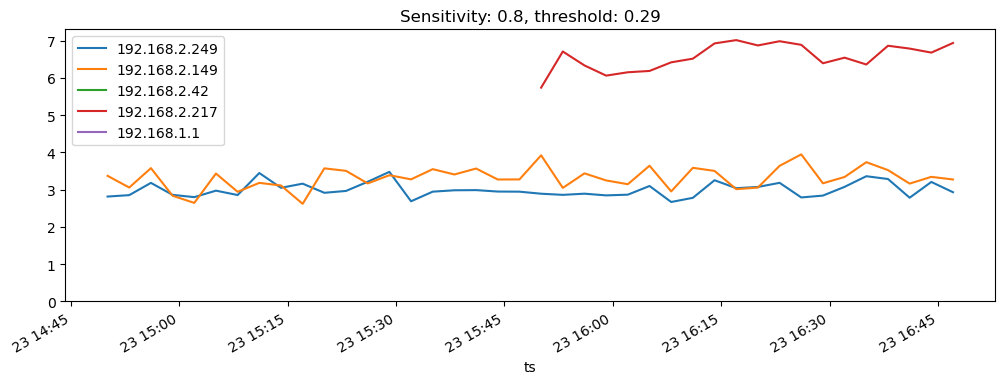

0.9


2023-03-25 11:07:19,813 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


2023-03-25 11:07:20,229 - distributed.worker - ERROR - Exception during execution of task lambda-b9bee8721595e57bdc3c3b8571876110.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-ef0bf44a-fc34-4dcb-92ec-4fedd81aaa4c'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:20,551 - distributed.worker - ERROR - Exception during execution of task lambda-8cd0217ec7809f4933a6821e91d985ab.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-29a32a83-5923-44d6-b002-f3662ed794d7'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:22,011 - distributed.worker - ERROR - Exception during execution of task lambda-997e4aee6fcd13f6cb832bb1a7ae25a4.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-d7967000-e67c-4fee-9f4c-b45f4cc8e8b8'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:22,343 - distributed.worker - ERROR - Exception during execution of task lambda-0f39471d4adce230589f93af56c959cb.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-c53e5259-b45f-4576-963f-3ffe78a2b7ee'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:25,573 - distributed.worker - ERROR - Exception during execution of task lambda-d769387523fd7f6db01f9f72efed1fb8.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-4c56216c-b790-4fd8-add0-be979e884615'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

2023-03-25 11:07:25,908 - distributed.worker - ERROR - Exception during execution of task lambda-5ef1e2b93505c93bc84368d05ace8ca3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-40c460de-10ac-4c72-9dea-7455afbd2ef9'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

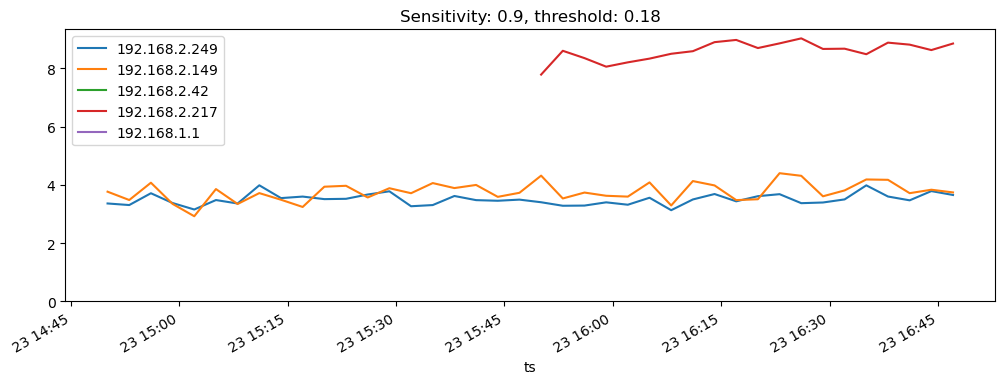

In [23]:
import matplotlib.pyplot as plt

for sensitivity, value in data.items():
    print(sensitivity)
    fig, axs = plt.subplots(ncols=1, figsize=(12, 4))
    df_calcs = value["df_calc"]
    for host in local_ips:
        df_calc_host = df_calcs[df_calcs["index"] == host].set_index("ts")
        df_calc_host["rate_log"].plot(label=f'{host}', ax=axs)

    plt.ylim(ymin=0)
    plt.title(f"Sensitivity: {sensitivity}, threshold: {value['threshold']}")
    plt.legend()
    plt.show()